#_Question 1

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models

2022-04-17 17:25:17.682199: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-17 17:25:17.682224: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 讀取資料集

In [2]:
PATH_TO_DATASET_FOLDER = pathlib.Path("HW4_MNIST_train/4")
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WEIDTH = 128

TRAINING_RATIO = 0.8
TESTING_RATIO = 0.1
VALIDATION_RATIO = 1 - TRAINING_RATIO - TESTING_RATIO

assert VALIDATION_RATIO >= 0

list_ds = tf.data.Dataset.list_files(str(PATH_TO_DATASET_FOLDER/"*.png"))

def process_file(file_path):
    bounding_box_info_file = tf.strings.join([
        tf.strings.substr(file_path, 0, tf.strings.length(file_path)-len(".png")),
        ".txt"
    ])
    infos = tf.strings.split(tf.io.read_file(bounding_box_info_file), '\t')
    infos = tf.map_fn(lambda x:tf.strings.to_number(x, tf.float32), infos, tf.float32)

    image = tf.io.decode_png(
        tf.io.read_file(file_path),
        channels=1
    )

    classification = tf.one_hot(tf.cast(infos[0], tf.int32), depth=10)

    return image, (classification, infos[1], infos[2], infos[3], infos[4])


list_ds = list_ds.map(process_file)

train_size = int(TRAINING_RATIO * len(list_ds))
test_size = int(TESTING_RATIO * len(list_ds))

train_ds = list_ds.take(train_size).batch(BATCH_SIZE)
test_ds = list_ds.skip(train_size).take(test_size).batch(BATCH_SIZE)
valid_ds = list_ds.skip(train_size).skip(test_size).batch(1)

2022-04-17 17:25:21.111800: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-17 17:25:21.111885: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-17 17:25:21.111919: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (haeter-notebook): /proc/driver/nvidia/version does not exist
2022-04-17 17:25:21.113373: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Use fn_output_signature instead


## 建構與訓練模型

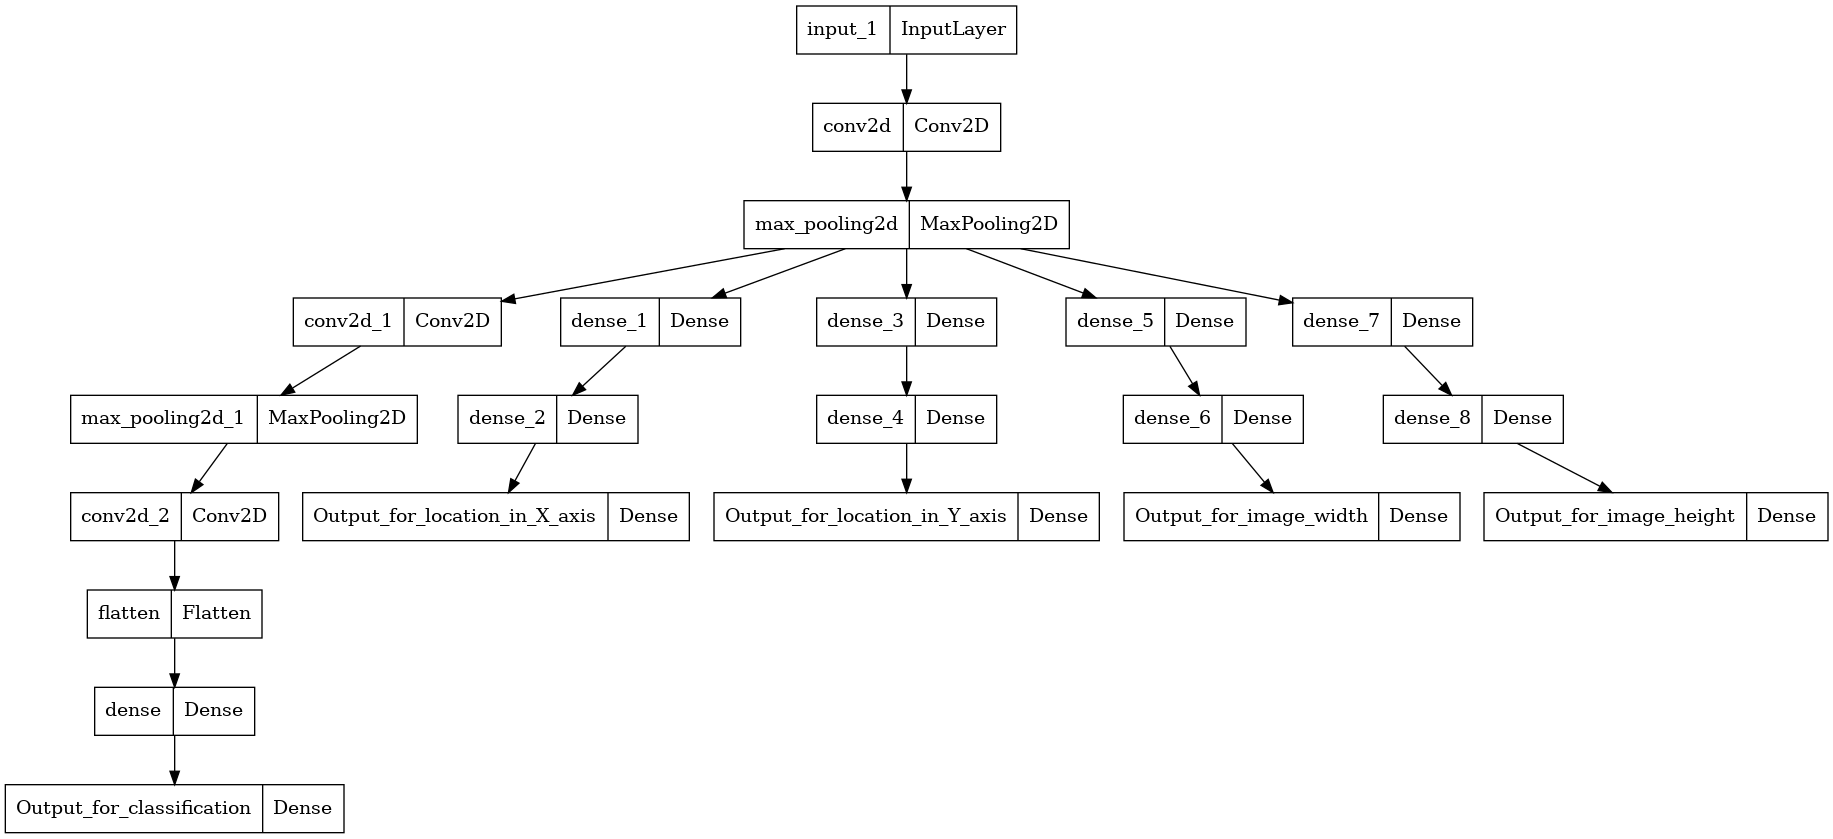

In [3]:
input_layer = layers.Input(shape=(IMG_HEIGHT, IMG_HEIGHT, 1))
gen_part = layers.Conv2D(IMG_HEIGHT, (5,5), input_shape=(None, IMG_HEIGHT, IMG_HEIGHT, 1))(input_layer)
gen_part = layers.MaxPooling2D(pool_size=(3, 3))(gen_part)

# Class of images
class_layer = layers.Conv2D(57, (3,3), activation='relu')(gen_part)
class_layer = layers.MaxPooling2D(pool_size=(2, 2))(class_layer)
class_layer = layers.Conv2D(55, (3,3), activation='relu')(class_layer)
class_layer = layers.Flatten()(class_layer)
class_layer = layers.Dense(22, activation='relu')(class_layer)
class_layer = layers.Dense(10, activation='sigmoid', name="Output_for_classification")(class_layer)

# X
x_layer = layers.Dense(16, activation='relu')(gen_part)
x_layer = layers.Dense(8, activation='relu')(x_layer)
x_layer = layers.Dense(1, name="Output_for_location_in_X_axis")(x_layer)

# Y
y_layer = layers.Dense(16, activation='relu')(gen_part)
y_layer = layers.Dense(8, activation='relu')(y_layer)
y_layer = layers.Dense(1, name="Output_for_location_in_Y_axis")(y_layer)

# width
width_layer = layers.Dense(16, activation='relu')(gen_part)
width_layer = layers.Dense(8, activation='relu')(width_layer)
width_layer = layers.Dense(1, name="Output_for_image_width")(width_layer)

# height
height_layer = layers.Dense(16, activation='relu')(gen_part)
height_layer = layers.Dense(8, activation='relu')(height_layer)
height_layer = layers.Dense(1, name="Output_for_image_height")(height_layer)

model = tf.keras.Model(inputs=input_layer, outputs=[class_layer, x_layer, y_layer, width_layer, height_layer])
model.compile(
    optimizer='Adam',
    loss={
        'Output_for_classification':'CategoricalCrossentropy',
        'Output_for_location_in_X_axis':'MSE',
        'Output_for_location_in_Y_axis':'MSE',
        'Output_for_image_width':'MSE',
        'Output_for_image_height':'MSE'
    },
    metrics={
        'Output_for_classification':'TopKCategoricalAccuracy',
        'Output_for_location_in_X_axis':'MSE',
        'Output_for_location_in_Y_axis':'MSE',
        'Output_for_image_width':'MSE',
        'Output_for_image_height':'MSE'
    }
)
tf.keras.utils.plot_model(model)

In [11]:
checkpoint_path = 'training_hw4/question1_model-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname('training_hw4/question1_model.ckpt')

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
    callbacks=[cp_callback]
)

Epoch 1/10


KeyboardInterrupt: 

## 讀取模型

In [ ]:
model.load_weights(checkpoint_path)

## 呈現結果

In [4]:
ds = next(list(valid_ds.take(1)))
result = model.predict(ds)

Confusion Matrix

In [ ]:
print(result)

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


Top-1 & top-3 accuracy

Intersection over Union

Network Architecture

# Question 2
## 讀取資料集

## 建構模型

## 讀取模型

## 呈現結果